# Mapping a Stretched Exponential Relaxation Model to 5-Dim Spectroscopic Piezoforce Microscopy (PFM) Data

Author: Nick Mostovych (from my PhD work)

**Objective:**

Analyze 5-dimentional spectroscopic PFM Data, which I obtained doing 10+hour/scan PFM studies of a novel piezoelectric material system called BNKT-BMT. I want to model the mechanical relaxation behavior as a function of position to see if there is spatial variation across the 2D map scanned. I want to see if there are "fast" and "slow" relaxing regions and how big they are.  

**Background:**

The research objective was to optimze the properties of a piezoelectric material system I developed called (1-x)Bi1/2(Na0.78K0.22)1/2TiO3  ̶  xBiMg1/2Ti1/2O3 (BNKT-BMT). Piezoelectrics are a class of materials that have excellent electromechanical coupling properties. They convert electrical energy to mechanical energy (or vice-versa). We use these materials in many applications ranging from the accelerometers in our cellphones to the fuel injectors in our cars. The doping level (amount of BMT for BNKT-BMT) determines how good these electromechanical properties are. However the science behind what exactly happends with doping is not yet well understood, which limits our ability to optimize these materials fully. The macroscopic properties as a function of doping are well documented. But, what is happening on an atomic scall is not yet well understood. PFM is a scanning probe spectorscopy measurment that can give us localized information about the electomechanical properties of a piezoelectric material down to the nanometer scale. I want to see what happends at various doping levels because just thre right amount of fast and slow regions on the microscopic scale, translates to an optimzed macroscopic performance on the macroscopic scale. I am attemping to quantify spatial variation of relaxation beat just the right size regions The experiments performed which resulted in theses datasets 

**What is the Data:**

Large ~ 20 GB datasets organized in a HDF5 file (Hierarchical Data Format 5). The raw data is the amplitude and phase responses of an electrically conducting nano-cantilever raster scanning (interacting) with 2D surface. The cantilever is stimulated by a chirp exitation pulse at over a frequency band. A DC drive waveform is superimposed ontop to apply different voltage levels. Measurements of the amplitude response are taken both in the "on state" (DC bias on) and "off state" (DC bias off). To study the relaxation data, I am taking many successive measurements as a function of time for each "off state". X-position, Y-position, frequency, DC bias and time make up the 5 dimentions of the dataset. The amplitude and phase cantilever deflection response is recorded as a complex number for each of these spectroscopic conditions

Spectroscopic Dimensions: X, Y, ω, V, t  = 50 x 50 x 203 x 32 x 64 = Very Large Datasets

position:  x-y grid (50x50) = 2500
frequency: 203 
DC bias:   32
Time:      64

Datasets are flattened to be 2D for simplicity of analysis purposes: dataset (spatial, other spectroscopic)

**What I will do with the Data:**

1. Organize the data to seperate the "off state" raw data from the "on state" I want to work with the "off state"  
2. Find the resonance data for each position, DC bias and time; fitting it to a simple harmonic oscillator (SHO) model and create a new SHO dataset only with the resonance data
3. Map a relaxation model to the SHO dataset and create a relaxation dataset composed of a custom datatype, which is composed of all of the model parameters
4. Check that the model makes sense and see what fast and slow regions look like using the Beta parameter of a stretched exponential for comparison
5. Anylyze the results and draw conclusions about spatial variation of relaxation behavior as a function of BMT doping 

**Hypothesis:**

High %BMT doping concentrations will result in strong spatial variation in relaxation behavior compared to low doping concentrations

**Publications and Patents:**

This work resulted in publications and patents:
https://aip.scitation.org/doi/10.1063/1.5143947,
US10421277B2,
US10252525B2

**References:**

Inspiration and code sections have been modified from various works from the following scientists:
Suhas Somnath, Chris R. Smith and Stephen Jesse at Oakridge National Lab (Developers of pyUSID and pycroscopy)

### Import modules and set everything up

In [38]:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
from os import path

# Warning package in case something goes wrong
from warnings import warn

# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    pip.main(['install', 'wget'])
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.widgets as mpw
from IPython.display import display, clear_output, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Pycroscopy for spectroscopic image data scientific analysis:
try:
    import pycroscopy as px
except ImportError:
    warn('pycroscopy not found.  Will install with pip.')
    import pip
    pip.main(['install', 'pycroscopy'])
    import pycroscopy as px
import pyUSID as usid    
    
    
# Setup interactive plotting
%matplotlib notebook
%matplotlib inline

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### Note on Pycroscopy and pyUSID

Pycroscopy / pyUSID is a python module developed by scientists at Oakridge National Lab and the Big-Data Spectroscopy community. Many modules and functions in this notebook are from pycroscopy/pyUSID as it has been developed for scpectrocipic scientific analysis, working with large HDF5 files.


# Let's get started!

### Make sure we have enough memory for modelling computations 

In [39]:
print('Available memory in this machine: {} GB'.format(usid.io_utils.get_available_memory()/1024**3))

Available memory in this machine: 11.575386047363281 GB


/home/mosto/anaconda3/lib/python3.8/site-packages/pyUSID/io/io_utils.py:249: FutureWarning: Please use pyUSID.processing.comp_utils.get_available_memory() instead in the future
  warn('Please use pyUSID.processing.comp_utils.get_available_memory() instead in the future', FutureWarning)


In [40]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024, so we don't hog all of our memory on the machine 
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

### Define custom datatype to orgnaize parameterized output from our model

In [41]:
'''
Custom dtype for the datasets created during fitting.
'''
field_names = ['R0', 'R1', 'Tk', 'Beta']
relax32 = np.dtype({'names': field_names,
                  'formats': [np.float32 for name in field_names]})

### Define a class to perform the fitting of our model to the dataset and also write results back to HDF5 file

In [42]:
class RelaxFit(usid.Process):
    
    def __init__(self, h5_main, cores=None, verbose=None):
        """
        Parameters
        ----------
        h5_main - dataset to compute on
        cores - Number of CPU cores to use for computation - Optional, None = all
        """
        super(RelaxFit, self).__init__(h5_main, cores=cores, verbose=verbose)
        
        self._verbose = verbose
        '''
        Pull some important metadata from main dataset
        For example: Number of repeat measurements done per given drive voltage and position
        '''
        self.Pulse_Repeat_Num = self.h5_main.spec_dim_sizes[0]
        # Number of voltage values in DC drive waveform
        self.DC_Offset_Num = self.h5_main.spec_dim_sizes[1]
        # Number of Positions
        self.num_pix = self.h5_main.h5_pos_inds.shape[0]
        # Get Spectroscopic Information Such as DC Bias Values
        self.bias_vals = self.h5_main.get_spec_values('DC_Offset')
        
    def test(self, pixel_ind, Vslice):
        """
        Test the algorithm on a single pixel

        Parameters
        ----------
        pixel_ind : uint
            Index of the pixel in the dataset that the process needs to be tested on.
        Vsclie : unit
            Provide a an integer between 0-31 for a voltage value from the drive waveform
        """
        # Now we specify the pixel
        
        amp = self.h5_main[pixel_ind,:]
        amp_reshaped = amp.reshape(-1,self.Pulse_Repeat_Num)
        amp_response = amp_reshaped[Vslice, :]
        
        
        # Next, apply the map function to the amplitude response. done!
        return self._map_function(amp_response)
    
    def _read_data_chunk(self):  
                                                         
        if self._start_pos < self.h5_main.shape[0]:
            self._end_pos = int(min(self.h5_main.shape[0], self._start_pos + self._max_pos_per_read))
            self.data = self.h5_main[self._start_pos:self._end_pos, :]
            if self.verbose:
                print('Reading pixels {} to {} of {}'.format(self._start_pos, self._end_pos, self.h5_main.shape[0]))

            # DON'T update the start position

        else:
            if self.verbose:
                print('Finished reading all data!')
            self.data = None                        
                                
        if self.data is not None:
            if self._verbose:
                print('Got raw data of shape {} from super'.format(self.data.shape))
            self.data = self.data.reshape(self.data.shape[0]* int(self.DC_Offset_Num), -1)
            if self._verbose:
                print('Reshaped raw data to shape {}'.format(self.data.shape))   
                                
             

    def _create_results_datasets(self):
        """
        Creates the datasets an Groups necessary to store the results.
        There are three operations happening in this function:
        1. Creation of HDF5 group to hold results
        2. Writing relevant metadata to this HDF5 group
        3. Creation of a HDF5 dataset to hold results
        """
        
        self.process_name = 'Relax_Fitting'

        # 1. create a HDF5 group to hold the results
        self.h5_results_grp = usid.hdf_utils.create_results_group(self.h5_main, self.process_name)

        # 2. Write relevant metadata to the group
        usid.hdf_utils.write_simple_attrs(self.h5_results_grp,
                                        {'last_pixel': 0, 'algorithm': 'curve_fit'})

        # Explicitly stating all the inputs to write_main_dataset
        # The process will reduce the spectra at each position to a single value
        # Therefore, the result is a 2D dataset with the same number of positions as self.h5_main 
        results_shape = (self.num_pix, self.DC_Offset_Num)
        results_dset_name = 'Amplitude_Response_fit_parameters'
        results_quantity = 'Amplitude'
        results_units = 'V'
        pos_dims = None # Reusing those linked to self.h5_main
        spec_dims = usid.write_utils.Dimension('DC_Offset', 'V', self.bias_vals)

        # Create an empty results dataset that will hold all the results
        self.h5_results = usid.hdf_utils.write_main_dataset(self.h5_results_grp, results_shape, results_dset_name,
                                                          results_quantity, results_units, pos_dims, spec_dims,
                                                          dtype=relax32,
                                                          h5_pos_inds=self.h5_main.h5_pos_inds,
                                                          h5_pos_vals=self.h5_main.h5_pos_vals)
                
        # Note that this function automatically creates the ancillary datasets and links them.

        print('Finshed creating datasets')

    def _write_results_chunk(self):
        """
        Write the computed results back to the H5
        In this case, there isn't any more additional post-processing required
        """
        # Reshape operation to have (P*N) shape, which we iterate map_function over
        # Recall that the results from the computation are stored in a list called self._results
        # self._results = np.array(self._results)  # convert from list to numpy array
        # self._results = self._results.reshape(-1, int(self.DC_Offset_Num))
        # Now self._results is of shape (P, N) and we can store it in the HDF5 dataset                                              
        
        self._results = np.array(self._results)
        if self._verbose:
                print('Results chunk has shape {}'.format(self._results.shape))
        self._results = self._results.reshape(-1, int(self.DC_Offset_Num))
        if self._verbose:
                print('Reshaped results chunk back to original shape {}'.format(self._results.shape))
                print(self._results)
        print(self._results.shape)
                                                      
        # write the results to the file
        self.h5_results[self._start_pos: self._end_pos, :] = self._results
        
        #self._results = np.array(self._results, dtype=np.float32)
        #self.h5_results = px.dtype_utils.stack_real_to_compound(self._results, relax32) 
        #self.h5_results = px.dtype_utils.stack_real_to_compound(self._results, relax32)
        #self.h5_results = np.append(self.h5_results, px.dtype_utils.stack_real_to_compound(self._results, relax32))
        
        # Flush the results to ensure that they have indeed been written to the file
        self.h5_main.file.flush()

        # update the 'last_pixel' to indicate that the process was succesfully completed on this many positions:
        self.h5_results_grp.attrs['last_pixel'] = self._end_pos

        # Now update the start position
        self._start_pos = self._end_pos

    @staticmethod
    def _map_function(amp_response, *args, **kwargs):
        """
        This is the function that will be applied to each pixel in the dataset.
        It's job is to demonstrate what needs to be done for each pixel in the dataset.
        pycroscopy.Process will handle the parallel computation and memory management
        """
        x1 = np.arange(amp_response.size)
        y1 = amp_response['Amplitude [V]']
        
        try:
    
            from scipy.optimize import curve_fit
            def fitFunc(x, R0, R1, Tk, Beta):
                return R0+R1*np.exp(-(x1/Tk)**Beta)
            fitParams, fitCovariances = curve_fit(fitFunc, x1, y1, p0=(1e-4,1e-4,50,4e-1),
                                                  bounds=([-np.inf, -np.inf, -np.inf, 0],
                                                          [np.inf, np.inf, np.inf, 1.0]))
            
        except RuntimeError:
            fitParams = np.array([0, 0, 0, 0])
        fitParams = usid.dtype_utils.stack_real_to_compound(fitParams, relax32)
        return fitParams     

### Load dataset and apply correct translators for HDF5 file

In [43]:
folder_path = r'/home/mosto/Documents/phddocs/ornl/testing of processed files'
file_name = r'X4A_Relax_50x50_0003_split_shofit.h5'

tl = px.io.translators.LabViewH5Patcher()
h5_file = h5py.File(tl.translate(path.join(folder_path, file_name)),mode='r+')

# Point an object to all the main datasets
datasets = usid.hdf_utils.get_all_main(h5_file)

File is already Pycroscopy ready.


### Explore HDF5 file

In [44]:
# We can see the whole tree data structure
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-IF_Split_000
      ---------------------
      ├ In_Field_Data
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-OF_Split_000
      ---------------------
      ├ Out_Field_Data
      ├ Out_Field_Data-SHO_Fit_000
        --------------------------
        ├ Fit
        ├ Fit-Relax_Fitting_000
          ---------------------
          ├ Amplitude_Response_fit_parameters
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
        ├ Guess
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially

### What did the raw data look like?

In [45]:
rawscan=datasets[0]
rawscan

<HDF5 dataset "Raw_Data": shape (2500, 441728), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	  (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 50 
	Y - size: 50 
Spectroscopic Dimensions: 
	Frequency - size: 203 
	Pulse_Repeat - size: 64 
	DC_Offset - size: 32 
	Field - size: 2
Data Type:
	complex64

### Let's look at the first measurement

It is an "in field" (Field = 0); at [x,y] = (0,0); at the first frequency; before the time domain (pulse repeat)

Just for context look at one example:

In [46]:
rawscan[0,0]

(-0.001266206+0.0032581633j)

### We can grab the spectroscopic values linked to the raw data

For example lets look at the DC_Offset values for the whole raw dataset

<function matplotlib.pyplot.show(*args, **kw)>

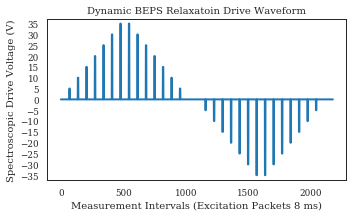

In [47]:
drive=rawscan.h5_spec_vals[2,:]

import seaborn as sns
sns.set(context='paper', style='white', palette='deep', 
            font='serif', font_scale=1, color_codes=True) 
from cycler import cycler
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
sns.set_palette('tab10') 
# if there are <= 10 datasets to compare, use tab10 instead

textsize=10

plottitle = 'Dynamic BEPS Relaxatoin Drive Waveform'

widthd = 2

fig, axes = plt.subplots(figsize = (5,3))

axes.plot(drive[::203]*10,linewidth=widthd)
axes.set_title(plottitle,size=textsize)
axes.set_xlabel('Measurement Intervals (Excitation Packets 8 ms)',fontsize=textsize)
axes.set_ylabel('Spectroscopic Drive Voltage (V)',fontsize=textsize)
# axes.set_ylim([0.0,0.5])
axes.set_ylim([-37,37])
axes.set_yticks(np.arange(-35,36,5))
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=.15,right=None, top=None, wspace=None, hspace=None)
#plt.savefig('/home/mosto/Documents/phddocs/pres_data/'+plottitle+'.png',dpi=1000)
plt.show

### We actualy want to work with the off field "out field" data for relaxation measurements

This has already been split up and created as a new group in the HDF5 File

In [48]:
outfield=datasets[2]
outfield

<HDF5 dataset "Out_Field_Data": shape (2500, 415744), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data-OF_Split_000/Out_Field_Data 
Data contains: 
	Unknown quantity (Unknown units) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 50 
	Y - size: 50 
Spectroscopic Dimensions: 
	Frequency - size: 203 
	Pulse_Repeat - size: 64 
	DC_Offset - size: 32
Data Type:
	complex64

# Let's jump ahead and work with the resonance data (already some processing and analysis done)

### Define the SHO Fit Main Dataset we want to work with

The SHO fit already done in previous calculations has taken the complex number deflection response of the frequency chirp and applied the Fast Fourier Transform (FFT) to work within the real Amplitude/Phase domain. We have the data stored in a compound dtype with Amplitude [V], Frequency [Hz], Quality Factor, Phase [rad], R2 Criterion

Here we look at the out of field resonance data

In [49]:
h5_main = datasets[3]
h5_main

<HDF5 dataset "Fit": shape (2500, 2048), type "|V20">
located at: 
	/Measurement_000/Channel_000/Raw_Data-OF_Split_000/Out_Field_Data-SHO_Fit_000/Fit 
Data contains: 
	SHO (compound) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 50 
	Y - size: 50 
Spectroscopic Dimensions: 
	Pulse_Repeat - size: 64 
	DC_Offset - size: 32
Data Fields:
	Amplitude [V], Frequency [Hz], Quality Factor, Phase [rad], R2 Criterion

### Let's check a datapoint

It is at [x,y] = (0,0); T = first time block; V = 0 V;

In [50]:
h5_main[0,0]

(0.00033893, 383072.75, 128.08499, -0.15425414, 0.83493817)

# Moving on to actually modelling the relaxation data 

### Instantiate the fitting class

In [51]:
fitter = RelaxFit(h5_main,verbose=True)

No mpi4py found or script was not called via mpixexec / mpirun. Assuming single node computation
Rank 0 - on socket with 4 logical cores and 11.57 GB avail. RAM shared by 1 ranks each given 3 cores.
Allowed to read 34952 pixels per chunk
It appears that this class may not be able to resume computations
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file


### Define R-Squared function to check varience of fit data associated with model.

In [52]:
# We want to know how well our data fits the model from the least squares fit linear regression
# one quick test is to check the R-squared and see how much of the variance can explained by the model
def Rsquared(ydata, yfit):
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared
    return r_squared

### First test 1 pixel by using the .test method from fitting class 

<ipython-input-42-247d7dbce582>:160: RuntimeWarning: invalid value encountered in power
  return R0+R1*np.exp(-(x1/Tk)**Beta)


[2.6241000e-04 6.3695764e-04 1.4382755e+01 4.7222748e-01]


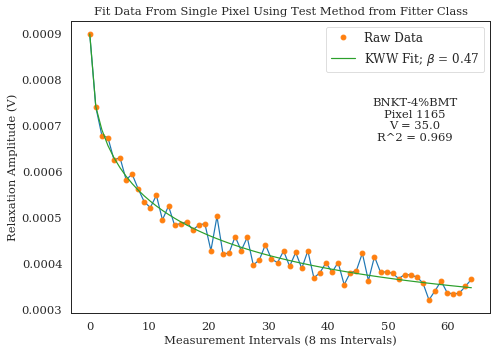

In [53]:
# Test the fitting function on one pixel of the dataset
# Extract some metadata:
num_rows, num_cols = h5_main.pos_dim_sizes

title='example of a functional fit'

row_ind, col_ind = 23, 15
pixel_ind = col_ind + row_ind * num_cols
#pixel_ind = 2060
Vslice = 8
size=12

# Testing is as simple as supplying a pixel index
rp = fitter.test(pixel_ind, Vslice)
relax_params = np.array([rp['R0'],rp['R1'],rp['Tk'],rp['Beta']])
print(relax_params)

amp_data = h5_main[:]['Amplitude [V]']
amp_data = amp_data.reshape(fitter.num_pix,-1,fitter.Pulse_Repeat_Num)

x1 = np.linspace(0, 64, 64)
y1 = amp_data[pixel_ind,Vslice,:]

def fitFunc(x, R0, R1, Tk, Beta):
        return R0+R1*np.exp(-(x1/Tk)**Beta)

fig, axes = plt.subplots(figsize = (7,5))

plt.plot(x1,y1)
plt.tight_layout()
#plt.title('BNKT4BMT Relaxation at V = ' + str(10*fitter.bias_vals[Vslice])+' : Pixel '+str(pixel_ind))
plt.title('Fit Data From Single Pixel Using Test Method from Fitter Class',size='large')
plt.xlabel('Measurement Intervals (8 ms Intervals)',fontsize='large')
plt.ylabel('Relaxation Amplitude (V)',fontsize='large')
xx = np.linspace(0, 64, 64)
yy = fitFunc(xx, *relax_params)

r_squared = np.round(Rsquared(y1,yy),3)
    

plt.plot(x1,y1,'o',label='Raw Data')
plt.plot(xx, yy,label=r'KWW Fit; $\beta$ = '+str(np.round(relax_params[3],2)))

axes.tick_params(labelsize='large')
plt.legend(prop={'size':size})

fig.text(0.83, 0.6, 'BNKT-4%BMT\nPixel '+str(pixel_ind)+'\nV = ' + str(10*fitter.bias_vals[Vslice])
         +'\nR^2 = ' +str(r_squared), ha='center', fontsize='large')
plt.tight_layout()
#plt.savefig('/home/mosto/Documents/phddocs/pres_data/'+title+'.png',dpi=1000)

### After testing a few pixels and we think the model is reasonable, lets map the model function to the whole dataset

We will create a new group in the HDF5 file and populate it with the parameterized data from the model fit

The fitting takes a long time (~2 hours), so we are going to use a previous fit performed, which is already in the HDF5 file

In [54]:
# Fit the data to the stretched exponential model and parameterize it
h5_relax_fit_group = usid.hdf_utils.find_results_groups(h5_main, 'Relax_Fitting')
# Check if we already have the fit data group in the file
if len(h5_relax_fit_group) == 0:
    fitter = RelaxFit(h5_main,verbose=True)
    h5_results_grp = fitter.compute(override=True, verbose=True)    
else:
    print('Use previous fit results already present in file')
#Check all the main datasets to see which one is the fit data.  Usually it is second to last
fit_data = usid.hdf_utils.get_all_main(h5_file)[-2]

Use previous fit results already present in file


### Define the fit dataset

In [55]:
# Check the new fitted data object
fit_data

<HDF5 dataset "Amplitude_Response_fit_parameters": shape (2500, 32), type "|V16">
located at: 
	/Measurement_000/Channel_000/Raw_Data-OF_Split_000/Out_Field_Data-SHO_Fit_000/Fit-Relax_Fitting_000/Amplitude_Response_fit_parameters 
Data contains: 
	Amplitude (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 50 
	Y - size: 50 
Spectroscopic Dimensions: 
	DC_Offset - size: 32
Data Fields:
	R0, R1, Tk, Beta

### Check that it is flattened (position, spectroscopic) ; then grab all the spectroscopic values and indices

We will revert the flattening to seperate the X,Y values for plotting and analysis reasons

Also want to easily reference all the spectroscopic values for plotting and analyis

In [56]:
fit_data.shape

(2500, 32)

In [57]:
# Get aux dataset information
h5_pos_inds = fit_data.h5_pos_inds
h5_pos_vals = fit_data.h5_pos_vals
h5_spec_inds = fit_data.h5_spec_inds
h5_spec_vals = fit_data.h5_spec_vals
pos_sort = usid.hdf_utils.get_sort_order(np.transpose(h5_pos_inds))
pos_dims = usid.hdf_utils.get_dimensionality(np.transpose(h5_pos_inds), pos_sort)
pos_labels = np.array(h5_pos_inds.attrs['labels'])[pos_sort]
print(pos_labels, pos_dims)

[b'X' b'Y'] [50, 50]


In [58]:
# Get DC bias vector values to have indices for slicing
dc_vec = h5_main.get_spec_values('DC_Offset')

### Quick check if we can pull the model parameters as a function of position

Here we look at the Beta parameter because that describes the speed of the relaxation behavior

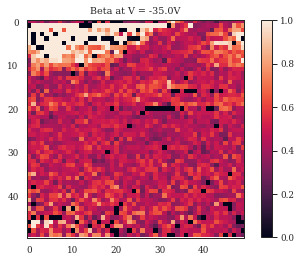

In [59]:
#Plot a voltage slice

slice_num = 23
plt.figure()
plt.imshow(fit_data[:,slice_num]['Beta'].reshape(pos_dims))
plt.title('Beta at V = '+str(dc_vec[slice_num]*10)+ 'V')
plt.colorbar()

# Let's do some interactive visualization!

### First some setup

In [60]:
# Changing matplotlib backend for interactive visualization
# Helps to call it twice and it is necessary to import matplotlib again
%matplotlib notebook
%matplotlib notebook 
import matplotlib.pyplot as plt

In [61]:
# Reshape fit data to deflatten the position dimention
ds_nd, success, labels = usid.hdf_utils.reshape_to_n_dims(fit_data, get_labels=True)
print('Shape of the N-dimensional dataset:', ds_nd.shape)
print(labels)
print('Field names of compound datatype:')
print(field_names)

Shape of the N-dimensional dataset: (50, 50, 32)
['X' 'Y' 'DC_Offset']
Field names of compound datatype:
['R0', 'R1', 'Tk', 'Beta']


<IPython.core.display.Javascript object>


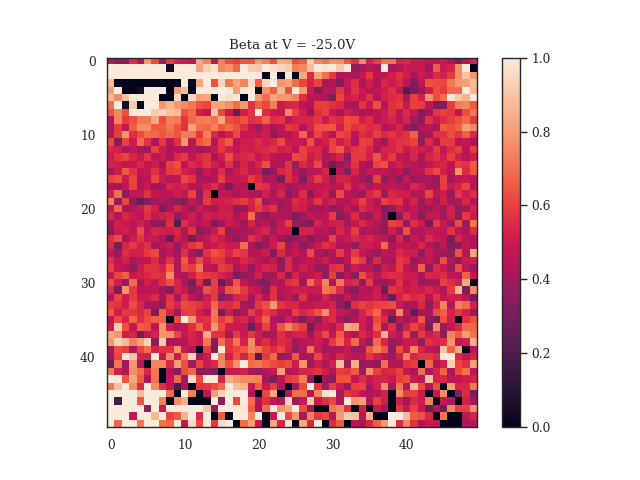

In [62]:
# Check that spatial plotting worked correctly for chosen spectroscopic value
slice_num = 21
plt.figure()
plt.imshow(ds_nd[:,:,slice_num]['Beta'].T)
plt.title('Beta at V = '+str(dc_vec[slice_num]*10)+ 'V')
plt.colorbar()

### Let's first try a static plot

<IPython.core.display.Javascript object>


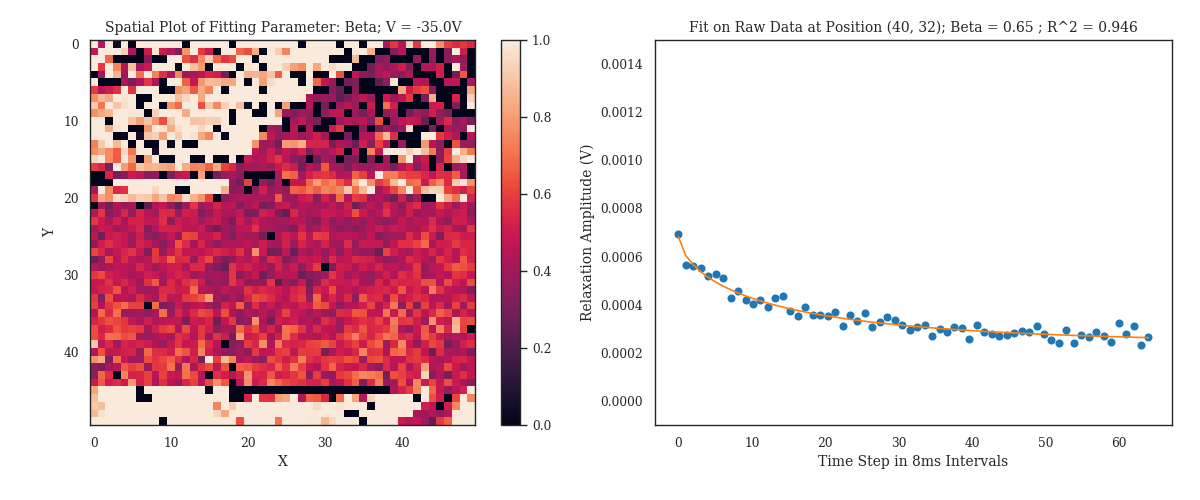

In [63]:
#First Try a Static Plot 
# Want LHS = Spatial Map of a chosen parameter
# Want RHS = Inherits data of a chosen pixel from LHS and does something with it
field_ind = 23
num_cols, num_rows  = h5_main.pos_dim_sizes
x, y = 40, 32
pixel_ind = x + y * num_cols
amp_data = h5_main[:]['Amplitude [V]']
amp_data = amp_data.reshape(fitter.num_pix,-1,fitter.Pulse_Repeat_Num)

x1 = np.linspace(0, 64, 64)
y1 = amp_data[pixel_ind,Vslice,:]

relax_params = [ds_nd[x,y,Vslice][name] for name in field_names]

def fitFunc(x, R0, R1, Tk, Beta):
        return R0+R1*np.exp(-(x1/Tk)**Beta)

xx = np.linspace(0, 64, 64)
yy = fitFunc(xx, *relax_params)

# Calculate Rsquared
r_squared = np.round(Rsquared(y1,yy),3)

# Define figures
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
# Plot parameter spatial map
im1 = axes[0].imshow(ds_nd[:,:,Vslice]['Beta'].T)

cbar1 = fig.colorbar(im1 ,ax=axes[0])

# For RHS we want to plot fit over raw data from a pixel
im2, = axes[1].plot(x1,y1,'o') 
im3, = axes[1].plot(xx, yy)
axes[1].set_ylim([-.0001, .0015])

for axis_ind, axis, title, axlabels in zip(range(2), axes,
                                ['Spatial Plot of Fitting Parameter: Beta', 'Fit on Raw data at Position '+str((x,y))],
                                [['X','Y'],['Time Step in 8ms Intervals','Relaxation Amplitude (V)']]):
    axis.set_title(title,fontsize=10)
    axis.set_xlabel(axlabels[0],fontsize=10) 
    axis.set_ylabel(axlabels[1],fontsize=10)

axes[1].set_title('Fit on Raw Data at Position '+str((x,y))+'; Beta = '+str(np.around(relax_params[3],2))+' ; R^2 = ' +str(r_squared),fontsize=10)
axes[0].set_title('Spatial Plot of Fitting Parameter: Beta; V = '+str(dc_vec[field_ind]*10)+ 'V',fontsize=10)



#axes[1].annotate('Beta = '+str(relax_params[3]), xy=(1, 1), xycoords='axes fraction', fontsize=16,
                 #xytext=(-5, -5), textcoords='offset points',
                #horizontalalignment='right', verticalalignment='top')

#for axis_ind, axis, title, axlabels in zip(range(2), axes,
                                #['Spatial Plot of Beta', 'Fit on Raw data at position '+str((x,y))],
                                #[['X','Y'],['Time Step In 8ms Intervals','Piezoresponse Amplitude (V)']]):
    #axis.set_title(title,fontsize=16)
    #axis.set_xlabel(axlabels[0],fontsize=14) 
    #axis.set_ylabel(axlabels[1],fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=.15,right=None, top=.92, wspace=None, hspace=None)

### Now dynamic / interactive plots

Best to look at high DC biases with lots of relaxation going on after large voltages applied

<IPython.core.display.Javascript object>


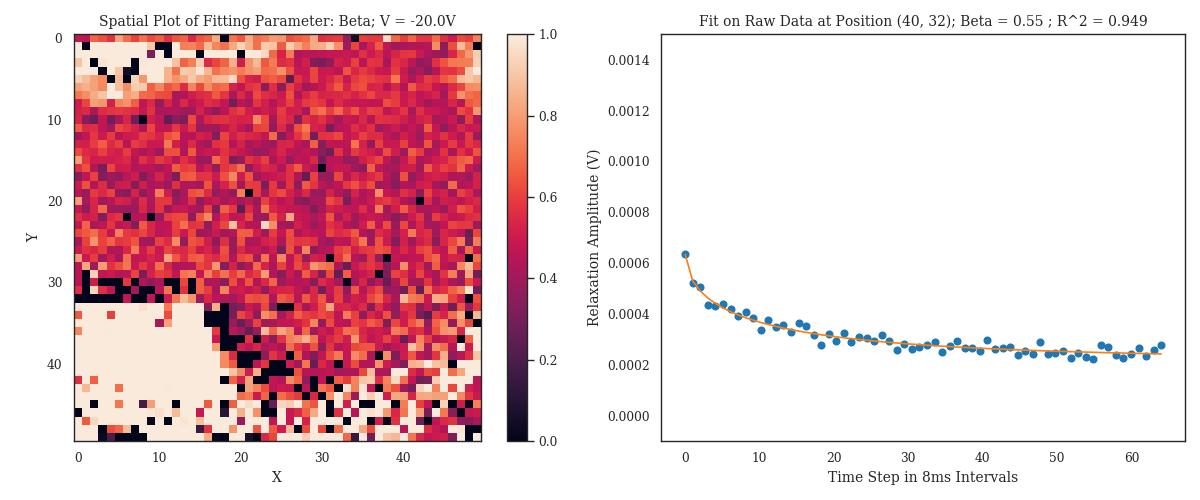

interactive(children=(IntSlider(value=24, description='X', max=49), IntSlider(value=24, description='Y', max=4…

In [64]:
# SECTION 1 - Dynamic PLOTS ----------------------------------

# The only difference with the previous cell is that this time, we hang onto
# the image handles so that we can update the plots

im_handles_lhs = []

col_ind = 49
row_ind = 49
field_ind = 23 


ds_nd_lhs = ds_nd[:,:,field_ind]['Beta']
ds_nd_rhs = ds_nd[row_ind,col_ind,field_ind]


num_rows, num_cols = h5_main.pos_dim_sizes

pixel_ind = col_ind + row_ind * num_cols
amp_data = h5_main[:]['Amplitude [V]']
amp_data = amp_data.reshape(fitter.num_pix,-1,fitter.Pulse_Repeat_Num)

x1 = np.linspace(0, 64, 64)
y1 = amp_data[pixel_ind,field_ind,:]

relax_params = [ds_nd[col_ind,row_ind,field_ind][name] for name in field_names]

def fitFunc(x, R0, R1, Tk, Beta):
        return R0+R1*np.exp(-(x1/Tk)**Beta)

xx = np.linspace(0, 64, 64)
yy = fitFunc(xx, *relax_params)

# Calculate Rsquared
r_squared = np.round(Rsquared(y1,yy),3)

# Define figures
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
# Plot parameter spatial map
im1 = axes[0].imshow(ds_nd_lhs.T)
# Add this image handle to the list above:
im_handles_lhs.append(im1)

cbar1 = fig.colorbar(im1 ,ax=axes[0])

# For RHS we want to plot fit over raw data from a pixel
im2, = axes[1].plot(x1,y1,'o') 
im3, = axes[1].plot(xx, yy)
axes[1].set_ylim([-.0001, .0015])                    


for axis_ind, axis, title, axlabels in zip(range(2), axes,
                                ['Spatial Plot of Fitting Parameter: Beta', 'Fit on Raw data at Position '+str((x,y))],
                                [['X','Y'],['Time Step in 8ms Intervals','Relaxation Amplitude (V)']]):
    axis.set_title(title,fontsize=10)
    axis.set_xlabel(axlabels[0],fontsize=10) 
    axis.set_ylabel(axlabels[1],fontsize=10)
plt.tight_layout()

# SECTION 2 - UPDATING FUNCTION ----------------------------------

def update_plots(**parms):
    # step 1: extracting the parameters
    col_ind = parms['X']
    row_ind = parms['Y']
    field_ind = parms['Field']
    
    print('Updated parameters received:', parms)
    
    # step 2: slicing the data 
    ds_nd_lhs = ds_nd[:,:,field_ind]['Beta']
    ds_nd_rhs = ds_nd[col_ind,row_ind,field_ind]
    
    pixel_ind = col_ind + row_ind * num_cols
    amp_data = h5_main[:]['Amplitude [V]']
    amp_data = amp_data.reshape(fitter.num_pix,-1,fitter.Pulse_Repeat_Num)
    
    x2 = np.linspace(0, 64, 64)
    y2 = amp_data[pixel_ind,field_ind,:]
    relax_params = [ds_nd[col_ind,row_ind,field_ind][name] for name in field_names]

    def fitFunc(x, R0, R1, Tk, Beta):
        return R0+R1*np.exp(-(x1/Tk)**Beta)

    xx2 = np.linspace(0, 64, 64)
    yy2 = fitFunc(xx, *relax_params)
    
    # Calculate Rsquared
    r_squared = np.round(Rsquared(y2,yy2),3)
    
    # step 3: only update the data of each plot instead of redrawing:
    for im_handle in im_handles_lhs:
        im_handle.set_data(ds_nd_lhs.T)
        im2.set_ydata(y2)
        plt.draw()
        im3.set_ydata(yy2)
        plt.draw()
        axes[1].set_title('Fit on Raw Data at Position '+str((x,y))+'; Beta = '+str(np.around(relax_params[3],2))+' ; R^2 = ' +str(r_squared),fontsize=10)
        axes[0].set_title('Spatial Plot of Fitting Parameter: Beta; V = '+str(dc_vec[field_ind]*10)+ 'V',fontsize=10)
        
        
    
    
    # step 4: request to update the figure:
    #display(fig)
    
# SECTION 3 - SET UP PARAMETERS FOR AND CALL INTERACTIVE FUNCTION -------------

# make this more automated:
parms = {'X':(0,49,1), 'Y':(0,49,1), 'Field':(0,31,1)}

widgets.interact(update_plots, **parms);    

In [36]:
#Close the file to free up the RAM memory!!
h5_file.flush()
h5_file.close()

# Summary

This notebook perfomed a fit of the resononance relaxation data of BNKT-4%BMT (after the DC drive stimulus) to a stretched exponential model. The (Beta) parameter describes the rate of the relaxation and allows for the visualization of "fast" and "slow" relaxing regions. We can link this back to the spatially dependent amplitude and phase reponse. This is done using .Gif videos for the different composition series. 

**Conclusion:**

We clearly see fast and slow relaxing regions in the highly doped 4%BMT material system

To draw further implications from this data, we need to compare the composition series. Specifically look at the Beta maps vs Amplitude and Phase maps as a function of BMT composition.